# Introduction

This notebook contains the implementation of most basic version of Diffusion model - Denoising Diffusion Probabilistic Model. This notebook is a fruit of my effort to learn diffusion from scratch. I aim to cover the following topics in Diffusion - 
- Denoising Diffusion Probabilistic Model (DDPM) &#9989;
- Denoising Diffusion Implicit Model (DDIM)
- Classifier based Guided Diffusion
- Classifier free Diffusion
- ControlNet
- Stable Diffusion
- Flow based Models

This series is nothing but an aim to enhance my own understanding. I will categorically enumerate all the resources where I learn the theory and also the code repositories from where I take the code so that any one who also wants to understand these topics can use this resource and built their own understanding

This is the first notebook in this series where we start with **Denoising Diffusion Probabilistic Models (DDPM)**


# Notes

1. I do not aim to make the notebook comprehensive, rather to provide resources that I myself found useful and create a notebook that others can play with or others can use as reference.
2. Therefore, it won't be possible for me to cover the mathematics, rather I will point to the papers, videos, or blogs that will do the job in much elegent and beautiful manner than me.
3. I will try my best to cite the source where I take the code from, but if I forget to do so, please remind me if any source is not mentioned. 

# General Resources



I think these are the topics one should be aware of before embarking on not only diffusion but to understand any generative models deeply. The topics are 
- Random Variable
- Probability Distribution
- Expectation
- Objective of Generative Modeling

If you are already aware of the above topic, please skip forward to later section in the notebook, but here are few lectures by Professor Prathosh from IISc that I found very helpful and I would urge anyone to watch if they have time 
- [Lecture 1 - Introduction to Probabilty, Part 1](https://www.youtube.com/watch?v=dNJsaX0C1fg&list=PLL1s8qiaGy0LwIajdxKZr_FRL7KZeQK9r&index=34)
- [Lecture 2 - Introduction to Probability, Part 2](https://www.youtube.com/watch?v=SkbrWcPTpzs&list=PLL1s8qiaGy0LwIajdxKZr_FRL7KZeQK9r&index=32)
- [Lecture 3 - Introduction to Generative Modeling](https://www.youtube.com/watch?v=uQvtdAPjKqI&list=PLL1s8qiaGy0LwIajdxKZr_FRL7KZeQK9r&index=31)

For an in depth resource of many of the topics in generative Modeling, the [whole playlist by Professor Prathosh](https://www.youtube.com/playlist?list=PLWqt_iRKPSLUOCesd16dYOe7FEM7NMrqs) can be an excellent companion

# Resources for DDPM 
To get in depth understanding of the mathematics of the DDPM, you can refer to the following [tutorial paper](https://arxiv.org/pdf/2208.11970). This paper provides every proof and doesn't gloss over like many of the tutorials. 

If you want something short yet capturing decent amount of details, you can watch this [video](https://www.youtube.com/watch?v=H45lF4sUgiE) by **ExplainingAI**

**Code Source**

The code is taken from the following [github repository](https://github.com/explainingai-code/DDPM-Pytorch/tree/main) by ExplainingAI. Here is the [video](https://www.youtube.com/watch?v=vu6eKteJWew) where he walks you through the whole code.

# DDPM Model

The model consist of mainly two Parts 

**Scheduler**

The job of the scheduler is to add noise and to sample a data point from previous timestep $t - 1$ given a sample of timestep $t$

**UNet**

Unlike VAE where we learn to both encode and decode, in DDPM we only learn how to decode. 
For decoder the most common architecture used is UNet

## Noise Scheduler


In [1]:
import torch

class LinearNoiseScheduler:
    def __init__(self, num_timesteps, beta_start,  beta_end):
        self.beta_start = beta_start
        self.beta_end = beta_end 
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps)
        self.alphas = 1 - self.betas

        self.alphas_cumprod = torch.cumprod(self.alphas, dim = 0)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1-self.alphas_cumprod)

    def add_noise(self, original, noise, t):
        original_shape = original.shape
        batch_size = original_shape[0]

        sqrt_alpha_cumprod = self.sqrt_alphas_cumprod.to(original.device)[t].reshape(batch_size)
        sqrt_one_minus_alpha_cumprod = self.sqrt_one_minus_alphas_cumprod.to(original.device)[t].reshape(batch_size)

        for _ in range(len(original_shape)-1):
            sqrt_alpha_cumprod = sqrt_alpha_cumprod.unsqueeze(-1)
            sqrt_one_minus_alpha_cumprod = sqrt_one_minus_alpha_cumprod.unsqueeze(-1)

        return sqrt_alpha_cumprod.to(original.device) * original + sqrt_one_minus_alpha_cumprod.to(original.device) * noise

    def sample_prev(self, xt, noise_pred, t):
        x0 = xt - (self.sqrt_one_minus_alphas_cumprod.to(xt.device)[t])* noise_pred
        x0 = x0/self.sqrt_alphas_cumprod.to(xt.device)[t]
        x0 = torch.clamp(x0, -1, 1)

        mean = xt - (self.betas.to(xt.device)[t] * noise_pred)/self.sqrt_one_minus_alphas_cumprod.to(xt.device)[t]
        mean = mean/torch.sqrt(self.alphas.to(xt.device)[t])
        if t==0:
            return mean, x0
        else:
            variance = (self.betas.to(xt.device)[t] * (1 - self.alphas_cumprod.to(xt.device)[t-1]))/(1-self.alphas_cumprod.to(xt.device)[t])
            z = torch.randn(xt.shape).to(xt.device)
            sigma = variance ** 0.5
            prev = mean + sigma * z
            return prev, x0
             
        

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Time Embedding Layer (Similar to Transformer Position Embedding)

In [3]:
import torch
import torch.nn as nn

def get_time_embedding(timesteps, t_emb_dim):
    factor = 10000 ** (torch.arange(
        start = 0, end = t_emb_dim // 2, device = timesteps.device)/(t_emb_dim//2)
                       )
    t_emb = timesteps[:, None].repeat(1, t_emb_dim // 2)/factor 
    t_emb = torch.cat([torch.sin(t_emb), torch.cos(t_emb)], dim = -1)
    return t_emb


## DownBlocks

In [4]:

class DownBlock(nn.Module):
    r"""
    Down conv block with attention.
    Sequence of following block
    1. Resnet block with time embedding
    2. Attention block
    3. Downsample using 2x2 average pooling
    """
    def __init__(self, in_channels, out_channels, t_emb_dim,
                 down_sample=True, num_heads=4, num_layers=1):
        super().__init__()
        self.num_layers = num_layers
        self.down_sample = down_sample
        self.resnet_conv_first = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, in_channels if i == 0 else out_channels),
                    nn.SiLU(),
                    nn.Conv2d(in_channels if i == 0 else out_channels, out_channels,
                              kernel_size=3, stride=1, padding=1),
                )
                for i in range(num_layers)
            ]
        )
        self.t_emb_layers = nn.ModuleList([
            nn.Sequential(
                nn.SiLU(),
                nn.Linear(t_emb_dim, out_channels)
            )
            for _ in range(num_layers)
        ])
        self.resnet_conv_second = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, out_channels),
                    nn.SiLU(),
                    nn.Conv2d(out_channels, out_channels,
                              kernel_size=3, stride=1, padding=1),
                )
                for _ in range(num_layers)
            ]
        )
        self.attention_norms = nn.ModuleList(
            [nn.GroupNorm(8, out_channels)
             for _ in range(num_layers)]
        )
        
        self.attentions = nn.ModuleList(
            [nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
             for _ in range(num_layers)]
        )
        self.residual_input_conv = nn.ModuleList(
            [
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1)
                for i in range(num_layers)
            ]
        )
        self.down_sample_conv = nn.Conv2d(out_channels, out_channels,
                                          4, 2, 1) if self.down_sample else nn.Identity()
    
    def forward(self, x, t_emb):
        out = x
        for i in range(self.num_layers):
            
            # Resnet block of Unet
            resnet_input = out
            out = self.resnet_conv_first[i](out)
            out = out + self.t_emb_layers[i](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i](out)
            out = out + self.residual_input_conv[i](resnet_input)
            
            # Attention block of Unet
            batch_size, channels, h, w = out.shape
            in_attn = out.reshape(batch_size, channels, h * w)
            in_attn = self.attention_norms[i](in_attn)
            in_attn = in_attn.transpose(1, 2)
            out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
            out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
            out = out + out_attn
            
        out = self.down_sample_conv(out)
        return out


## MidBlocks

In [5]:

class MidBlock(nn.Module):
    r"""
    Mid conv block with attention.
    Sequence of following blocks
    1. Resnet block with time embedding
    2. Attention block
    3. Resnet block with time embedding
    """
    def __init__(self, in_channels, out_channels, t_emb_dim, num_heads=4, num_layers=1):
        super().__init__()
        self.num_layers = num_layers
        self.resnet_conv_first = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, in_channels if i == 0 else out_channels),
                    nn.SiLU(),
                    nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=3, stride=1,
                              padding=1),
                )
                for i in range(num_layers+1)
            ]
        )
        self.t_emb_layers = nn.ModuleList([
            nn.Sequential(
                nn.SiLU(),
                nn.Linear(t_emb_dim, out_channels)
            )
            for _ in range(num_layers + 1)
        ])
        self.resnet_conv_second = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, out_channels),
                    nn.SiLU(),
                    nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                )
                for _ in range(num_layers+1)
            ]
        )
        
        self.attention_norms = nn.ModuleList(
            [nn.GroupNorm(8, out_channels)
                for _ in range(num_layers)]
        )
        
        self.attentions = nn.ModuleList(
            [nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
                for _ in range(num_layers)]
        )
        self.residual_input_conv = nn.ModuleList(
            [
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1)
                for i in range(num_layers+1)
            ]
        )
    
    def forward(self, x, t_emb):
        out = x
        
        # First resnet block
        resnet_input = out
        out = self.resnet_conv_first[0](out)
        out = out + self.t_emb_layers[0](t_emb)[:, :, None, None]
        out = self.resnet_conv_second[0](out)
        out = out + self.residual_input_conv[0](resnet_input)
        
        for i in range(self.num_layers):
            
            # Attention Block
            batch_size, channels, h, w = out.shape
            in_attn = out.reshape(batch_size, channels, h * w)
            in_attn = self.attention_norms[i](in_attn)
            in_attn = in_attn.transpose(1, 2)
            out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
            out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
            out = out + out_attn
            
            # Resnet Block
            resnet_input = out
            out = self.resnet_conv_first[i+1](out)
            out = out + self.t_emb_layers[i+1](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i+1](out)
            out = out + self.residual_input_conv[i+1](resnet_input)
        
        return out


## UpBlocks

In [6]:

class UpBlock(nn.Module):
    r"""
    Up conv block with attention.
    Sequence of following blocks
    1. Upsample
    1. Concatenate Down block output
    2. Resnet block with time embedding
    3. Attention Block
    """
    def __init__(self, in_channels, out_channels, t_emb_dim, up_sample=True, num_heads=4, num_layers=1):
        super().__init__()
        self.num_layers = num_layers
        self.up_sample = up_sample
        self.resnet_conv_first = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, in_channels if i == 0 else out_channels),
                    nn.SiLU(),
                    nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=3, stride=1,
                              padding=1),
                )
                for i in range(num_layers)
            ]
        )
        self.t_emb_layers = nn.ModuleList([
            nn.Sequential(
                nn.SiLU(),
                nn.Linear(t_emb_dim, out_channels)
            )
            for _ in range(num_layers)
        ])
        self.resnet_conv_second = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, out_channels),
                    nn.SiLU(),
                    nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                )
                for _ in range(num_layers)
            ]
        )
        
        self.attention_norms = nn.ModuleList(
            [
                nn.GroupNorm(8, out_channels)
                for _ in range(num_layers)
            ]
        )
        
        self.attentions = nn.ModuleList(
            [
                nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
                for _ in range(num_layers)
            ]
        )
        self.residual_input_conv = nn.ModuleList(
            [
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1)
                for i in range(num_layers)
            ]
        )
        self.up_sample_conv = nn.ConvTranspose2d(in_channels // 2, in_channels // 2,
                                                 4, 2, 1) \
            if self.up_sample else nn.Identity()
    
    def forward(self, x, out_down, t_emb):
        x = self.up_sample_conv(x)
        x = torch.cat([x, out_down], dim=1)
        
        out = x
        for i in range(self.num_layers):
            resnet_input = out
            out = self.resnet_conv_first[i](out)
            out = out + self.t_emb_layers[i](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i](out)
            out = out + self.residual_input_conv[i](resnet_input)
            
            batch_size, channels, h, w = out.shape
            in_attn = out.reshape(batch_size, channels, h * w)
            in_attn = self.attention_norms[i](in_attn)
            in_attn = in_attn.transpose(1, 2)
            out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
            out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
            out = out + out_attn

        return out


## Whole Unet Model

In [7]:

class Unet(nn.Module):
    r"""
    Unet model comprising
    Down blocks, Midblocks and Uplocks
    """
    def __init__(self, im_channels):
        super().__init__()
        im_channels = im_channels
        self.down_channels = [32, 64, 128, 256]
        self.mid_channels = [256, 256, 128]
        self.t_emb_dim = 128
        self.down_sample = [True, True, False]
        self.num_down_layers = 2
        self.num_mid_layers = 2
        self.num_up_layers = 2
        
        assert self.mid_channels[0] == self.down_channels[-1]
        assert self.mid_channels[-1] == self.down_channels[-2]
        assert len(self.down_sample) == len(self.down_channels) - 1
        
        # Initial projection from sinusoidal time embedding
        self.t_proj = nn.Sequential(
            nn.Linear(self.t_emb_dim, self.t_emb_dim),
            nn.SiLU(),
            nn.Linear(self.t_emb_dim, self.t_emb_dim)
        )

        self.up_sample = list(reversed(self.down_sample))
        self.conv_in = nn.Conv2d(im_channels, self.down_channels[0], kernel_size=3, padding=(1, 1))
        
        self.downs = nn.ModuleList([])
        for i in range(len(self.down_channels)-1):
            self.downs.append(DownBlock(self.down_channels[i], self.down_channels[i+1], self.t_emb_dim,
                                        down_sample=self.down_sample[i], num_layers=self.num_down_layers))
        
        self.mids = nn.ModuleList([])
        for i in range(len(self.mid_channels)-1):
            self.mids.append(MidBlock(self.mid_channels[i], self.mid_channels[i+1], self.t_emb_dim,
                                      num_layers=self.num_mid_layers))
        
        self.ups = nn.ModuleList([])
        for i in reversed(range(len(self.down_channels)-1)):
            self.ups.append(UpBlock(self.down_channels[i] * 2, self.down_channels[i-1] if i != 0 else 16,
                                    self.t_emb_dim, up_sample=self.down_sample[i], num_layers=self.num_up_layers))
        
        self.norm_out = nn.GroupNorm(8, 16)
        self.conv_out = nn.Conv2d(16, im_channels, kernel_size=3, padding=1)
    
    def forward(self, x, t):
        # Shapes assuming downblocks are [C1, C2, C3, C4]
        # Shapes assuming midblocks are [C4, C4, C3]
        # Shapes assuming downsamples are [True, True, False]
        # B x C x H x W
        out = self.conv_in(x)
        # B x C1 x H x W
        
        # t_emb -> B x t_emb_dim
        t_emb = get_time_embedding(torch.as_tensor(t).long(), self.t_emb_dim)
        t_emb = self.t_proj(t_emb)
        
        down_outs = []
        
        for idx, down in enumerate(self.downs):
            down_outs.append(out)
            out = down(out, t_emb)
        # down_outs  [B x C1 x H x W, B x C2 x H/2 x W/2, B x C3 x H/4 x W/4]
        # out B x C4 x H/4 x W/4
            
        for mid in self.mids:
            out = mid(out, t_emb)
        # out B x C3 x H/4 x W/4
        
        for up in self.ups:
            down_out = down_outs.pop()
            out = up(out, down_out, t_emb)
            # out [B x C2 x H/4 x W/4, B x C1 x H/2 x W/2, B x 16 x H x W]
        out = self.norm_out(out)
        out = nn.SiLU()(out)
        out = self.conv_out(out)
        # out B x C x H x W
        return out

# DataLoader Creation

In [11]:
import torch 
from torch.utils.data import DataLoader 
from torchvision import datasets, transforms

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

train_dataset = datasets.MNIST(root='data', 
                              train = True, 
                              transform = transform,
                              download = True)
test_dataset = datasets.MNIST(root='data', 
                             train=False, 
                             transform = transform, 
                             download = True)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for images, labels in train_loader:
    print(images.shape, labels.shape)
    break

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 53.5MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.76MB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 14.6MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.62MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

torch.Size([64, 1, 28, 28]) torch.Size([64])


# Training

In [13]:
from torch.optim import Adam
from tqdm import tqdm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
beta_start = 0.0001
beta_end = 0.02
num_timesteps = 1000

In [15]:
import numpy as np
num_epochs = 25
unet = Unet(im_channels = 1).to(device)
optimizer = Adam(unet.parameters(), lr = 1e-4)
criterion = torch.nn.MSELoss()
scheduler = LinearNoiseScheduler(num_timesteps = num_timesteps, 
                                beta_start = beta_start,
                                beta_end = beta_end)

for epoch_idx in range(num_epochs):
    losses = []
    for im, _ in tqdm(train_loader):
        optimizer.zero_grad()
        im = im.float().to(device)

        noise = torch.randn_like(im).to(device)

        t = torch.randint(0, num_timesteps, (im.shape[0],)).to(device)

        noisy_im = scheduler.add_noise(im, noise, t)
        noise_pred = unet(noisy_im, t)

        loss = criterion(noise_pred, noise)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    print('Finished epoch:{} | Loss : {:.4f}'.format(
            epoch_idx + 1,
            np.mean(losses),
        ))
    print(f"{epoch_idx+1} epoch completed")

100%|██████████| 938/938 [03:26<00:00,  4.54it/s]


Finished epoch:1 | Loss : 0.0996
1 epoch completed


100%|██████████| 938/938 [03:25<00:00,  4.57it/s]


Finished epoch:2 | Loss : 0.0353
2 epoch completed


100%|██████████| 938/938 [03:25<00:00,  4.57it/s]


Finished epoch:3 | Loss : 0.0301
3 epoch completed


100%|██████████| 938/938 [03:25<00:00,  4.57it/s]


Finished epoch:4 | Loss : 0.0281
4 epoch completed


100%|██████████| 938/938 [03:25<00:00,  4.57it/s]


Finished epoch:5 | Loss : 0.0273
5 epoch completed


100%|██████████| 938/938 [03:25<00:00,  4.57it/s]


Finished epoch:6 | Loss : 0.0261
6 epoch completed


100%|██████████| 938/938 [03:24<00:00,  4.58it/s]


Finished epoch:7 | Loss : 0.0256
7 epoch completed


100%|██████████| 938/938 [03:24<00:00,  4.58it/s]


Finished epoch:8 | Loss : 0.0252
8 epoch completed


100%|██████████| 938/938 [03:24<00:00,  4.58it/s]


Finished epoch:9 | Loss : 0.0247
9 epoch completed


100%|██████████| 938/938 [03:24<00:00,  4.58it/s]


Finished epoch:10 | Loss : 0.0247
10 epoch completed


100%|██████████| 938/938 [03:25<00:00,  4.57it/s]


Finished epoch:11 | Loss : 0.0244
11 epoch completed


100%|██████████| 938/938 [03:25<00:00,  4.57it/s]


Finished epoch:12 | Loss : 0.0239
12 epoch completed


100%|██████████| 938/938 [03:25<00:00,  4.57it/s]


Finished epoch:13 | Loss : 0.0237
13 epoch completed


100%|██████████| 938/938 [03:24<00:00,  4.58it/s]


Finished epoch:14 | Loss : 0.0235
14 epoch completed


100%|██████████| 938/938 [03:24<00:00,  4.58it/s]


Finished epoch:15 | Loss : 0.0234
15 epoch completed


100%|██████████| 938/938 [03:25<00:00,  4.57it/s]


Finished epoch:16 | Loss : 0.0232
16 epoch completed


100%|██████████| 938/938 [03:25<00:00,  4.57it/s]


Finished epoch:17 | Loss : 0.0231
17 epoch completed


100%|██████████| 938/938 [03:25<00:00,  4.57it/s]


Finished epoch:18 | Loss : 0.0232
18 epoch completed


100%|██████████| 938/938 [03:25<00:00,  4.57it/s]


Finished epoch:19 | Loss : 0.0229
19 epoch completed


100%|██████████| 938/938 [03:25<00:00,  4.57it/s]


Finished epoch:20 | Loss : 0.0228
20 epoch completed


100%|██████████| 938/938 [03:25<00:00,  4.57it/s]


Finished epoch:21 | Loss : 0.0227
21 epoch completed


100%|██████████| 938/938 [03:25<00:00,  4.57it/s]


Finished epoch:22 | Loss : 0.0223
22 epoch completed


100%|██████████| 938/938 [03:25<00:00,  4.57it/s]


Finished epoch:23 | Loss : 0.0226
23 epoch completed


100%|██████████| 938/938 [03:25<00:00,  4.57it/s]


Finished epoch:24 | Loss : 0.0222
24 epoch completed


100%|██████████| 938/938 [03:25<00:00,  4.57it/s]

Finished epoch:25 | Loss : 0.0224
25 epoch completed


# Inference

1it [00:00,  5.24it/s]

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


1000it [00:26, 37.67it/s]


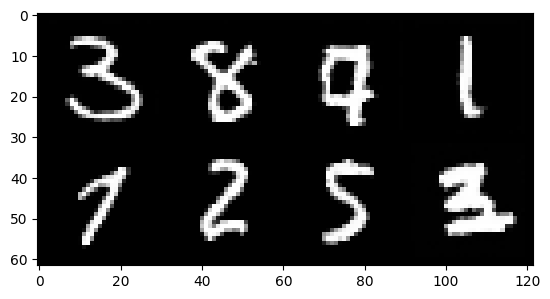

In [17]:
from torchvision.utils import make_grid 
from tqdm import tqdm 
import torchvision
import matplotlib.pyplot as plt

num_samples = 8

xt = torch.randn((num_samples, 1, 28, 28)).to(device)
img = None
with torch.no_grad():
    for i in tqdm(reversed(range(num_timesteps))):
        noise_pred = unet(xt, torch.as_tensor(i).unsqueeze(0).to(device))
        xt, x0_pred = scheduler.sample_prev(xt, noise_pred, torch.as_tensor(i).unsqueeze(0).to(device))
        ims = torch.clamp(xt, -1, 1.).detach().cpu()
        ims = (ims + 1)/2
        grid =make_grid(ims, nrow = 4)
        img = torchvision.transforms.ToPILImage()(grid)
        plt.imshow(img)
        

In [ ]:
plt.imshow(img)